## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 13:39:56--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  15.5MB/s    in 0.4s    

2025-03-02 13:39:57 (15.5 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

In [9]:
df_train

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50
...,...,...,...,...
1000204,5364,814,1,2000-04-26 02:35:41
1000205,5364,817,5,2000-04-25 23:21:27
1000206,5364,478,5,2000-04-25 23:19:06
1000207,5364,819,4,2000-04-26 02:20:48


##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [10]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:

    max_user_id = df['user_id'].max()
    max_item_id = df['item_id'].max()

    result = np.zeros((max_user_id + 1, max_item_id + 1))

    result[df['user_id'], df['item_id']] = df['rating']

    return result #shape ~ [n_users, n_items]

In [11]:
interactions = df_to_matrix(df_train)

In [12]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    user_ids = df['user_id'].astype('category').cat.codes
    item_ids = df['item_id'].astype('category').cat.codes
    result = coo_array((df['rating'], (user_ids, item_ids)))

    return result # coo_array

In [13]:
coo_interactions = df_to_coo(df_train)

In [14]:
df_train[(df_train['user_id'] == 0) & (df_train['item_id'] == 2994)]

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23


In [15]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [16]:
from numpy.linalg import svd
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [17]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    if isinstance(interractions, np.ndarray):
        U, S, V = svd(interractions, full_matrices=False)

        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]

    elif isinstance(interractions, sp.coo_array):
        interractions = interractions.astype(float)
        if n_singular_values == -1:
            n_singular_values = min(interractions.shape) - 1
        U, S, V = svds(interractions, k=n_singular_values)
        U = np.flip(U, axis=1)
        S = np.flip(S)
        V = np.flip(V, axis=0)

    return U, np.diag(S), V

In [18]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [ ]:
U.shape

(5365, 3010)

In [ ]:
V.shape

(3010, 3010)

In [19]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [30]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interractions, n_singular_values)
    rec_matrix = U @ S @ V

    mask = (interactions > 0).astype(int)
    scores = rec_matrix * (1 - mask)
    recommendations = np.argsort(-scores, axis=1)[:, :top_k]

    return recommendations #shape ~ [n_users, top_k]

In [31]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [32]:
from time import time
import matplotlib.pyplot as plt

In [ ]:
# gt_items = df_test.groupby('user_id')['item_id'].apply(list).to_dict()

In [39]:
def ndcg_metric(df_test, recs):
    gt_items = df_test.groupby('user_id')['item_id'].apply(list).to_dict()
    predicted = {user_id: list(recs[user_id]) for user_id in range(recs.shape[0])}
    ndcg_scores = []

    for user, pred_items in predicted.items():
        if user not in gt_items:
            continue

        true_items = gt_items[user]
        relevance = np.array([1 if item in true_items else 0 for item in pred_items])

        rank_dcg = dcg(relevance)
        if rank_dcg == 0:
            ndcg_scores.append(0)
            continue

        ideal_dcg = dcg(np.sort(relevance)[::-1])  # сортируем по убыванию
        if ideal_dcg == 0:
            ndcg_scores.append(0)
            continue

        ndcg_scores.append(rank_dcg / ideal_dcg)

    return np.mean(ndcg_scores) if ndcg_scores else 0

def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)

#def evaluate_recommender(df, model_preds, gt_col='test_interactions', topn=100):
#
#    metric_values = []

#    for idx, row in df.iterrows():
#        gt_items = [x[0] for x in row[gt_col]]
#        metric_values.append((ndcg_metric(gt_items, row[model_preds])))


#    return np.mean([x[0] for x in metric_values])

In [ ]:
def plot_graphs(interractions: Union[np.ndarray, coo_array], df_test, top_k: int = 100):
    metrics = []
    times = []
    gt_items = df_test.groupby('user_id')['item_id'].apply(list).to_dict()
    for n_singular_values in [1, 10, 50, 200, 1000]:
        start = time()
        recs = make_svd_recommendations(interactions, n_singular_values=n_singular_values)
        end = time()
        times.append(end - start)
        ndcg_scores = [ndcg_metric(gt_items.get(user, []), recs) for user, recs in enumerate(recs)]
        ndcg = np.mean(ndcg_scores)
        metrics.append(ndcg)
    # метрика
    plt.figure(figsize=(10, 5))
    plt.plot([1, 10, 50, 200, 1000], metrics, marker='o', linestyle='-')
    plt.xlabel("Количество сингулярных чисел")
    plt.ylabel("Средний NDCG")
    plt.title("Зависимость NDCG от количества сингулярных чисел")
    plt.grid(True)
    plt.show()

    # время
    plt.figure(figsize=(10, 5))
    plt.plot([1, 10, 50, 200, 1000], times, marker='o', linestyle='-', color='red')
    plt.xlabel("Количество сингулярных чисел")
    plt.ylabel("Время работы")
    plt.title("Зависимость времени работы от количества сингулярных чисел")
    plt.grid(True)
    plt.show()


In [ ]:
coo_interactions

<5365x3010 sparse array of type '<class 'numpy.int64'>'
	with 787420 stored elements in COOrdinate format>

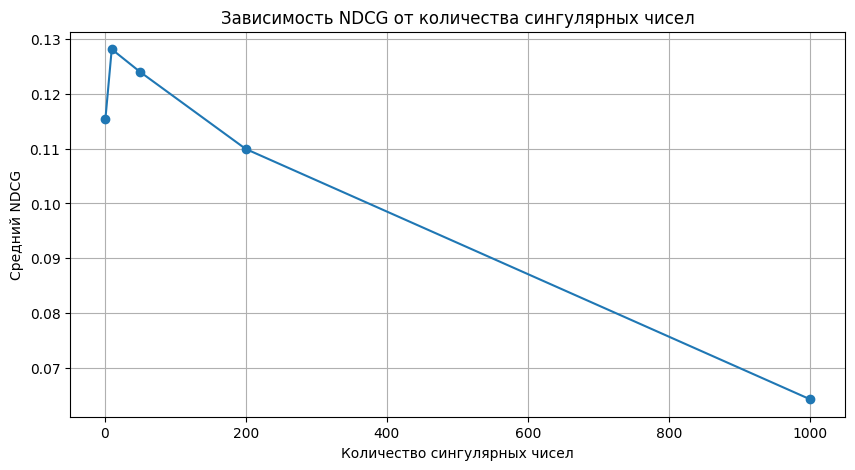

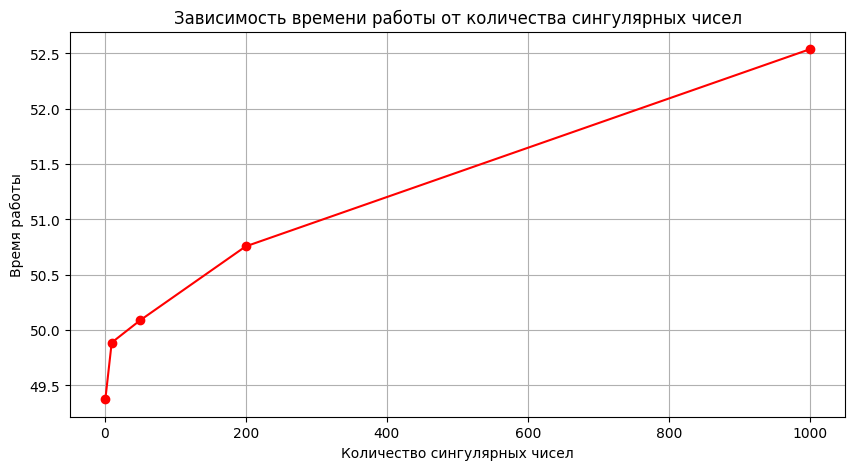

In [ ]:
plot_graphs(coo_interactions, df_test, top_k = 100)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [21]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.3 MB/s eta 0:00:00


In [22]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.1 MB/s eta 0:00:00


In [23]:
from implicit.als import AlternatingLeastSquares
import optuna
from scipy.sparse import coo_matrix, csr_matrix

In [24]:
def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):

    if isinstance(interactions, np.ndarray):
        interactions = coo_matrix(interactions)

    als_interactions = (interactions * alpha).astype(np.float32).tocsr()

    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=15,
        random_state=42
    )
    model.fit(als_interactions)

    user_ids = np.arange(als_interactions.shape[0])
    recommendations = np.zeros((als_interactions.shape[0], top_k), dtype=np.int32)

    for i, userid in enumerate(user_ids):
        recommended_items, _ = model.recommend(userid, als_interactions.getrow(userid), N=top_k, filter_already_liked_items=True)
        recommendations[i, :len(recommended_items)] = recommended_items

    return recommendations #shape ~ [n_users, top_k]

In [63]:
def objective(trial, interactions, df_test):
    gt_items = df_test.groupby('user_id')['item_id'].apply(list).to_dict()
    n_factors = trial.suggest_int("n_factors", 10, 200)
    alpha = trial.suggest_loguniform("alpha", 0.1, 100)
    reg = trial.suggest_loguniform("reg", 0.001, 1.0)

    model = AlternatingLeastSquares(factors=n_factors, regularization=reg, iterations=15, random_state=42)
    if isinstance(interactions, np.ndarray):
        interactions = coo_matrix(interactions)
    als_interactions = (interactions * alpha).astype(np.float32).tocsr()
    model.fit(als_interactions)

    user_ids = list(gt_items.keys())
    recommendations = np.zeros((len(user_ids), 100), dtype=int)

    for i, uid in enumerate(user_ids):
      recommendations[i] = model.recommend(uid, als_interactions.getrow(uid), N=100, filter_already_liked_items=True)[0]

    ndcg_score = ndcg_metric(df_test, recommendations)
    return ndcg_score

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, interactions, df_test), n_trials=20)

[I 2025-03-02 15:07:43,898] A new study created in memory with name: no-name-4ff07857-7e3c-4682-bc6c-1f96127e8a15
<ipython-input-63-afd49f233e79>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 0.1, 100)
<ipython-input-63-afd49f233e79>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  reg = trial.suggest_loguniform("reg", 0.001, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:08:00,625] Trial 0 finished with value: 0.365037933455647 and parameters: {'n_factors': 151, 'alpha': 22.959553451229485, 'reg': 0.6436205261608844}. Best is trial 0 with value: 0.365037933455647.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:08:12,170] Trial 1 finished with value: 0.3761029405641036 and parameters: {'n_factors': 135, 'alpha': 11.494188766354162, 'reg': 0.4963413873948777}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:08:23,843] Trial 2 finished with value: 0.3695051357694057 and parameters: {'n_factors': 50, 'alpha': 6.451517768001073, 'reg': 0.0013113931642234082}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:08:39,168] Trial 3 finished with value: 0.3666547623232014 and parameters: {'n_factors': 149, 'alpha': 1.5585118033835377, 'reg': 0.009251450892978757}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:08:57,153] Trial 4 finished with value: 0.34070111838689404 and parameters: {'n_factors': 191, 'alpha': 0.22524846903477766, 'reg': 0.2055266627102005}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:09:07,622] Trial 5 finished with value: 0.3565128792180243 and parameters: {'n_factors': 129, 'alpha': 52.29823474851691, 'reg': 0.011209681264317544}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:09:17,296] Trial 6 finished with value: 0.3732925732464644 and parameters: {'n_factors': 70, 'alpha': 2.691644096214109, 'reg': 0.024161536979017125}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:09:26,675] Trial 7 finished with value: 0.37231539971249017 and parameters: {'n_factors': 132, 'alpha': 1.2586713593330159, 'reg': 0.0040314471708476785}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:09:43,661] Trial 8 finished with value: 0.3559805267526825 and parameters: {'n_factors': 155, 'alpha': 24.69467584539922, 'reg': 0.01363316485435471}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:09:56,950] Trial 9 finished with value: 0.364690588414422 and parameters: {'n_factors': 170, 'alpha': 77.20503557451809, 'reg': 0.08429440811049008}. Best is trial 1 with value: 0.3761029405641036.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:10:04,319] Trial 10 finished with value: 0.40822442762828953 and parameters: {'n_factors': 15, 'alpha': 0.12542842333080725, 'reg': 0.948566561456987}. Best is trial 10 with value: 0.40822442762828953.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:10:11,224] Trial 11 finished with value: 0.41223492983212484 and parameters: {'n_factors': 11, 'alpha': 0.10884034483940784, 'reg': 0.7824738997526961}. Best is trial 11 with value: 0.41223492983212484.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:10:16,705] Trial 12 finished with value: 0.41261504448446423 and parameters: {'n_factors': 11, 'alpha': 0.12304760997069904, 'reg': 0.8946055819927732}. Best is trial 12 with value: 0.41261504448446423.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:10:23,345] Trial 13 finished with value: 0.40508527478063483 and parameters: {'n_factors': 11, 'alpha': 0.35787960835910404, 'reg': 0.11492953636884384}. Best is trial 12 with value: 0.41261504448446423.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:10:32,762] Trial 14 finished with value: 0.38965729079423467 and parameters: {'n_factors': 46, 'alpha': 0.5545895542128916, 'reg': 0.26914366122534583}. Best is trial 12 with value: 0.41261504448446423.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:10:46,476] Trial 15 finished with value: 0.379299805958756 and parameters: {'n_factors': 90, 'alpha': 0.1052258762203493, 'reg': 0.06998347031140523}. Best is trial 12 with value: 0.41261504448446423.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:10:55,028] Trial 16 finished with value: 0.39013932683419295 and parameters: {'n_factors': 35, 'alpha': 0.6302897725251575, 'reg': 0.37091324881309584}. Best is trial 12 with value: 0.41261504448446423.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:11:09,349] Trial 17 finished with value: 0.38062927862084955 and parameters: {'n_factors': 93, 'alpha': 0.20966538827682596, 'reg': 0.8849785504579448}. Best is trial 12 with value: 0.41261504448446423.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:11:18,875] Trial 18 finished with value: 0.3824904035794745 and parameters: {'n_factors': 68, 'alpha': 0.9452711389797772, 'reg': 0.16634970998348542}. Best is trial 12 with value: 0.41261504448446423.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 15:11:29,803] Trial 19 finished with value: 0.3986624088822788 and parameters: {'n_factors': 28, 'alpha': 0.21532570064106987, 'reg': 0.04774020221628209}. Best is trial 12 with value: 0.41261504448446423.


In [64]:
study.best_params, study.best_value

({'n_factors': 11, 'alpha': 0.12304760997069904, 'reg': 0.8946055819927732},
 0.41261504448446423)

In [40]:
ndcg_score = ndcg_metric(df_test, recs)
ndcg_score

0.31163467182797183

Лучший NDCG для SVD - 0.07, а для ALS - 0.6

In [65]:
recs_als = make_als_recommendations(interactions)
assert recs_als.shape == (interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [41]:
movies = pd.read_csv("ml-1m/movies.dat", sep="::", engine="python", names=["item_id", "title", "genres"], encoding="latin1")


In [42]:
movies

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [43]:
item_title = dict(zip(movies["item_id"], movies["title"]))

In [44]:
best_params = study.best_params
best_factors = best_params["n_factors"]
best_alpha = best_params["alpha"]
best_reg = best_params["reg"]

best_als = AlternatingLeastSquares(
    factors=best_factors,
    regularization=best_reg,
    iterations=15,
    random_state=42
)

als_interactions = (coo_matrix(interactions) * best_alpha).astype(np.float32).tocsr()

best_als.fit(als_interactions)

  0%|          | 0/15 [00:00<?, ?it/s]

In [101]:
def explanation(user_ids, model, interactions, recs, item_title, top_k=10):
  interactions = csr_matrix(interactions)
  for user in user_ids:
    print(f'Пользователь {user}:')
    user_rec = recs[user, :top_k]
    for item in user_rec:
      explaining = model.explain(user, interactions, item)
      title = item_title.get(item, "Фильм не найден")
      print(f'На рекомендацию {title} повлияли:')
      for inf_item, score in explaining[1]:
        inf_item_title = item_title.get(inf_item, "Фильм не найден")
        print(f' {inf_item_title} - {score}')

In [79]:
user_ids_unic = np.unique(als_interactions.nonzero()[0])
user_ids = np.random.choice(user_ids_unic, size=3, replace=False)

In [102]:
explanation(user_ids, best_als, interactions, recs_als, item_title, top_k=10)

Пользователь 3360:
На рекомендацию Фильм не найден повлияли:
 Фильм не найден - 0.026082561718382087
 Hustler White (1996) - 0.02298490533608875
 Nemesis 2: Nebula (1995) - 0.022712242534243185
 Crocodile Dundee (1986) - 0.02223521353303981
 Nine Months (1995) - 0.021276460063661073
 Pushing Hands (1992) - 0.02046423160406059
 Milk Money (1994) - 0.018043420701716762
 My Science Project (1985) - 0.017460186585883393
 When Harry Met Sally... (1989) - 0.017191949559264744
 Far Off Place, A (1993) - 0.016795658218113636
На рекомендацию Sneakers (1992) повлияли:
 Killer, The (Die xue shuang xiong) (1989) - 0.03804498248869702
 Фильм не найден - 0.0377994335044398
 Crocodile Dundee (1986) - 0.03612723538497278
 When Harry Met Sally... (1989) - 0.035363647310958285
 Hustler White (1996) - 0.03440517842087423
 Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995) - 0.034345799489331086
 Pushing Hands (1992) - 0.033314580234464444
 Laura (1944) - 0.03266906630407363
 Nemesis 2: Nebul

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)

In [45]:
df_train_1 = df_train.copy()
df_train_1['rating'] = 1
coo_1 = df_to_matrix(df_train_1)

In [46]:
recs_svd = make_svd_recommendations(coo_1, -1, 100)
ndcg_svd = ndcg_metric(df_test, recs_svd)

recs_als = make_als_recommendations(coo_1, top_k=100, n_factors=best_factors, alpha=best_alpha, regularization=best_reg)
ndcg_als = ndcg_metric(df_test, recs_als)

  0%|          | 0/15 [00:00<?, ?it/s]

In [47]:
print(f'NDCG SVD - {ndcg_svd}')
print(f'NDCG ALS - {ndcg_als}')

NDCG SVD - 0.3781302455344565
NDCG ALS - 0.5218541314926249


Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0

In [48]:
df_train

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50
...,...,...,...,...
1000204,5364,814,1,2000-04-26 02:35:41
1000205,5364,817,5,2000-04-25 23:21:27
1000206,5364,478,5,2000-04-25 23:19:06
1000207,5364,819,4,2000-04-26 02:20:48


In [49]:
df_train_2 = df_train.copy()
df_train_2['rating'] = df_train_2['rating'].apply(lambda x: 1 if x > 3 else 0)
coo_2 = df_to_matrix(df_train_2)

In [50]:
recs_svd = make_svd_recommendations(coo_2, -1, 100)
ndcg_svd = ndcg_metric(df_test, recs_svd)

recs_als = make_als_recommendations(coo_2, top_k=100, n_factors=best_factors, alpha=best_alpha, regularization=best_reg)
ndcg_als = ndcg_metric(df_test, recs_als)

  0%|          | 0/15 [00:00<?, ?it/s]

In [51]:
print(f'NDCG SVD - {ndcg_svd}')
print(f'NDCG ALS - {ndcg_als}')

NDCG SVD - 0.3658457969949774
NDCG ALS - 0.4898359973896872


Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1

In [52]:
df_train_3 = df_train.copy()
df_train_3['rating'] = df_train_3['rating'].apply(lambda x: 1 if x > 3 else -1)
coo_3 = df_to_matrix(df_train_3)

In [53]:
df_train_3['rating'].unique()

array([-1,  1])

In [54]:
df_train['rating'].unique()

array([3, 4, 1, 2, 5])

In [55]:
recs_svd = make_svd_recommendations(coo_3, -1, 100)
ndcg_svd = ndcg_metric(df_test, recs_svd)

recs_als = make_als_recommendations(coo_3, top_k=100, n_factors=best_factors, alpha=best_alpha, regularization=best_reg)
ndcg_als = ndcg_metric(df_test, recs_als)

  0%|          | 0/15 [00:00<?, ?it/s]

In [56]:
print(f'NDCG SVD - {ndcg_svd}')
print(f'NDCG ALS - {ndcg_als}')

NDCG SVD - 0.31370522993949884
NDCG ALS - 0.5338500578926174


Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы

In [57]:
df_train_4 = df_train.copy()
df_train_4['rating'] = df_train_3['rating'].apply(lambda x: 1 if x > 3 else -1)
max_date = df_train_4['datetime'].max()
df_train_4["months_ago"] = ((max_date - df_train_4["datetime"]) / np.timedelta64(30, "D")).astype(int)
decay = 0.9
df_train_4["weight"] = decay ** df_train_4["months_ago"]
coo_4 = df_to_matrix(df_train_4)

In [58]:
coo_4

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.]])

In [59]:
recs_svd = make_svd_recommendations(coo_4, -1, 100)
ndcg_svd = ndcg_metric(df_test, recs_svd)

recs_als = make_als_recommendations(coo_4, top_k=100, n_factors=best_factors, alpha=best_alpha, regularization=best_reg)
ndcg_als = ndcg_metric(df_test, recs_als)

  0%|          | 0/15 [00:00<?, ?it/s]

In [60]:
print(f'NDCG SVD - {ndcg_svd}')
print(f'NDCG ALS - {ndcg_als}')

NDCG SVD - 0.3196846114593723
NDCG ALS - 0.22347915514210162


##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [123]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factor = None
        self.item_factor = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 3):
        n_users, n_items = interactions.shape
        self.user_factor = np.random.normal(scale=1.0 / self.n_factors, size=(n_users, self.n_factors))
        self.item_factor = np.random.normal(scale=1.0 / self.n_factors, size=(n_items, self.n_factors))

        confidence = 1 + self.alpha * interactions

        for i in range(n_iterations):
          print(f' Iteration {i + 1}')
          self.user_factor = self.als_step(confidence, self.user_factor, self.item_factor)
          self.item_factor = self.als_step(confidence.T, self.item_factor, self.user_factor)

    def als_step(self, confidence, fixed_factors, variable_factors):
        lambda_I = self.reg_coef * np.eye(self.n_factors)
        YTY = variable_factors.T @ variable_factors
        updated_factors = np.zeros_like(fixed_factors)

        for i in range(fixed_factors.shape[0]):
            conf_diag = np.diag(confidence[i])
            YTCY = variable_factors.T @ conf_diag @ variable_factors
            updated_factors[i] = np.linalg.solve(YTY + YTCY + lambda_I, variable_factors.T @ (conf_diag @ confidence[i]))

        return updated_factors


    def predict(self, top_k: int = 100):
        scores = self.user_factors @ self.item_factors.T
        scores[interactions > 0] = -np.inf
        return np.argsort(-scores, axis=1)[:, :top_k]
        return predicts # shape ~ [n_users, top_k]

In [125]:
ials = iALS()

ials.fit(interactions)
pred = ials.predict()

 Iteration 1


KeyboardInterrupt: 

In [ ]:
ndcg_ials = ndcg_metric(df_test, pred)